In [1]:
import pandas as pd

from gensim import corpora, models, similarities
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

%matplotlib inline

In this section, we apply `Topic Modeling` to discover what are the main topics of the reviews. Considering the fact that reviews are about food products, we may get a feeling about the products with the most reviews. The `Latent Dirichlet Allocation` method is used, implemented in `Gensim` framework.

In [2]:
reviews_df = pd.read_csv('./Data/Reviews.csv')
reviews_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
reviews_df['Summary'] = reviews_df['Summary'].fillna('')
#Concatenating the review Summary and Text
review_content = (reviews_df['Summary'] + ' ' + reviews_df['Text']).tolist()

In [4]:
#Loading a set of English stopwords
english_stopset = set(stopwords.words('english')).union(
                  {"things", "that's", "something", "take", "don't", "may", "want", "you're", 
                   "set", "might", "says", "including", "lot", "much", "said", "know", 
                   "good", "step", "often", "going", "thing", "things", "think",
                  "back", "actually", "better", "look", "find", "right", "example", 
                   "verb", "verbs"})

In [5]:
#Tokenizing words of articles
tokenizer = RegexpTokenizer(r"(?u)[\b\#a-zA-Z][\w&-_]+\b")
review_tokens = list(map(lambda x: [token for token in tokenizer.tokenize(x.lower()) \
                                    if token not in english_stopset], review_content))

In [6]:
#Processing bigrams from unigrams (sets of two works frequently together in the corpus)
bigram_transformer = models.Phrases(review_tokens)
reviews_unigrams_bigrams_tokens = list(bigram_transformer[review_tokens])

/Users/aravanshad/miniconda2/envs/deeplearning/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [7]:
#Creating a dictionary and filtering out too rare and too common tokens
dictionary = corpora.Dictionary(reviews_unigrams_bigrams_tokens)
dictionary.filter_extremes(no_below=5, no_above=0.4, keep_n=None)
dictionary.compactify()
print(dictionary)

Dictionary(119183 unique tokens: ['appreciates', 'bought', 'canned', 'dog', 'finicky']...)


In [8]:
#Processing Bag-of-Words (BoW) for each review
reviews_bow = [dictionary.doc2bow(doc) for doc in reviews_unigrams_bigrams_tokens]

In [9]:
#Training the LDA topic model on reviews
lda_model = models.LdaModel(reviews_bow, id2word=dictionary, num_topics=30, passes=10, iterations=500)

In [10]:
#Processing the topics for each review
reviews_lda = lda_model[reviews_bow]

In [11]:
def get_topics_top_words(model, max_words):
    all_topics = model.show_topics(-1, max_words*2, False, False)
    topics = []
    for topic in all_topics:    
        min_score_word = float(abs(topic[1][0][1])) / 2.
        top_positive_words = list(map(lambda y: y[0].replace('_',' '), 
                                      filter(lambda x: x[1] > min_score_word, topic[1])))[0:max_words]
        topics.append('[' + ', '.join(top_positive_words) + ']')
    return topics

#Computing the main topic of each article
topics_top_words = get_topics_top_words(lda_model, 5)

Below, we can see the discovered topics in the products reviews, sorted by the number of reviews about the topics (popularity). It gives us an idea about what type of fine food products have the most reviews (chips, coffee, cookie, tea, etc.)

In [12]:
def get_main_topics(corpus_lda, topics_labels):
    min_strength = (1.0 / float(len(topics_labels))) + 0.01
    main_topics = map(lambda ts: sorted(ts, key=lambda t: -t[1])[0][0] if sorted(ts, key=lambda t: -t[1])[0][1] > min_strength else None, corpus_lda)
    main_topics_labels = map(lambda x: topics_labels[x] if x != None else '', main_topics)
    return list(main_topics_labels)

#Return the discovered topics, sorted by popularity
corpus_main_topics = get_main_topics(reviews_lda, topics_top_words)

main_topics_df = pd.DataFrame(corpus_main_topics, columns=['topic']).groupby('topic').size().sort_values(ascending=True).reset_index()
main_topics_df.columns = ['topic','count']
main_topics_df.sort_values('count', ascending=False)

,topic,count
30,"[like, taste, flavor]",80630
29,[great],59256
28,"[price, amazon, buy]",56072
27,"[sugar, water, milk, it's, like]",54427
26,[coffee],50560
25,"[one, get, like, would, it's]",47793
24,[food],34973
23,[tea],28637
22,"[cookies, snack, cookie, bars, yummy]",26485
21,"[dog, treats, dogs]",24189


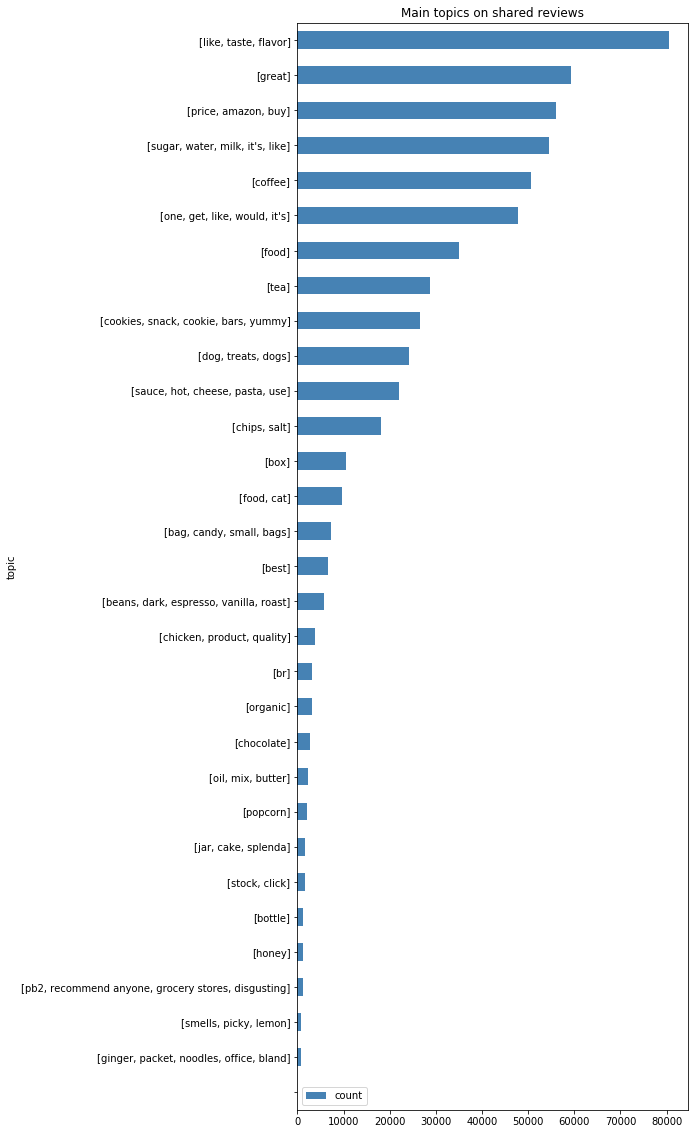

In [14]:
main_topics_df.plot(kind='barh', x='topic', y='count', 
                    figsize=(7,20), 
                    title='Main topics on shared reviews',
                    color='steelblue')